In [1]:
import socket
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
HOST = "127.0.0.1"

In [8]:
class FinalServer:
    def __init__(self, server_port, block_size=1024):
        self.server_port = server_port
        self.block_size = block_size
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.socket.bind((HOST, server_port))
        self.socket.listen()

    def run(self):
        with self.socket as s:
            print(f'Waiting for connection on port {self.server_port}.')
            conn, addr = s.accept()
            print(f'Connected. Port:{self.server_port}.')

            # receive image with noise
            self.img_noise = self.recv_image(conn)
            # receive origianl image
            self.img_orig = self.recv_image(conn)

        # denoise
        self.img_denoise = self.denoise(self.img_noise)

    def recv_image(self, conn):
        # Receiving image size
        h_bytes = conn.recv(4)
        h = int.from_bytes(h_bytes, byteorder='big')
        w_bytes = conn.recv(4)
        w = int.from_bytes(w_bytes, byteorder='big')
        print(f'Size of image h = {h} w = {w} was recieved.')

        # Receiving image
        n = h * w * 3
        n_iters = n // self.block_size
        n_remainder = n - n_iters * self.block_size
        img_bytes = []
        for i in range(n_iters):
            block = conn.recv(self.block_size)
            img_bytes.append(block)
        if n_remainder > 0:
            block = conn.recv(n_remainder)
            img_bytes.append(block)
        print('Image was received.')

        img_bytes_b = b''.join(img_bytes)
        img_np = np.frombuffer(img_bytes_b, dtype='uint8')
        img = img_np.reshape(h, w, 3)
        return img

    def denoise(self, image):
        return cv2.medianBlur(image, ksize=5)


In [9]:
finalserver = FinalServer(server_port=5066)
finalserver.run()

Waiting for connection on port 5066.
Connected. Port:5066.
Size of image h = 450 w = 800 was recieved.
Image was received.
Size of image h = 450 w = 800 was recieved.
Image was received.


In [11]:
img_orig = finalserver.img_orig
img_noise = finalserver.img_noise
img_denoise = finalserver.img_denoise

(450, 800, 3)


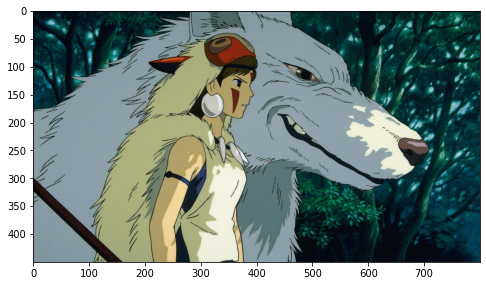

In [12]:
# Showing images
print(img_orig.shape)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

(450, 800, 3)


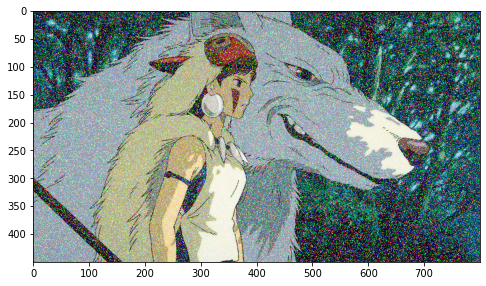

In [13]:
print(img_noise.shape)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_noise, cv2.COLOR_BGR2RGB))

(450, 800, 3)


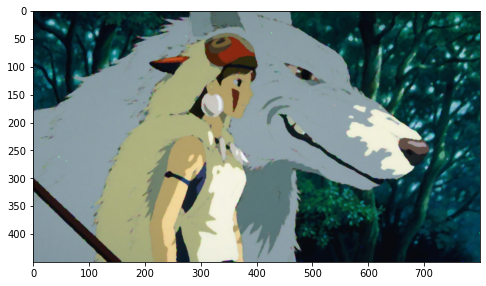

In [14]:
print(img_denoise.shape)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_denoise, cv2.COLOR_BGR2RGB))

In [24]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

In [25]:
def eval_dataloss(img1, img2):
    mse = np.square((img1 - img2).astype('float32')).mean()
    print('Mean Squared Error:', mse)
    ssi = structural_similarity(img1, img2, multichannel=True)
    print('Structural Similarity Index:', ssi) 
    psnr = peak_signal_noise_ratio(img1, img2)
    print('Peak signal-to-noise ratio:', psnr)

In [27]:
print('For image with noise')
eval_dataloss(img_orig,img_noise)
print('\nFor denoised image')
eval_dataloss(img_orig,img_denoise)

For image with noise
Mean Squared Error: 12734.473
Structural Similarity Index: 0.19305245530347234
Peak signal-to-noise ratio: 11.644885766565123

For denoised image
Mean Squared Error: 34062.137
Structural Similarity Index: 0.7690055470285632
Peak signal-to-noise ratio: 22.74523843358319
